In [1]:
print("测试连接")

测试连接


In [5]:
import os
from pathlib import Path
import pandas as pd
# 当前脚本文件路径
current_file_path = Path.cwd()
# 上一级文件夹路径
parent_folder_path = current_file_path.parent
#学校集群
Data_PATH = parent_folder_path / "mydata"
print(Data_PATH)
def load_data(csv_name):
    csv_path = os.path.join(Data_PATH, csv_name)
    return pd.read_csv(csv_path)

/public/home/zss/mydata


# 3.1.2 矢量化加速

In [4]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [7]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [8]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [9]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.24640 sec'

In [10]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00115 sec'

In [2]:
# 定义一个Python函数来计算正态分布
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

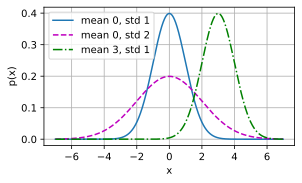

In [6]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
ylabel='p(x)', figsize=(4.5, 2.5),
legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 3.2 线性回归的从零开始实现

In [24]:
#生成数据集
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) #生成服从正态分布 N(0,1)的随机数矩阵。
    y = torch.matmul(X, w) + b #矩阵乘法，再+b
    y += torch.normal(0, 0.01, y.shape) #增加噪音
    return X, y.reshape((-1, 1))

这段代码定义了一个函数 `synthetic_data`，用于生成一个用于线性回归任务的数据集，包括特征和带噪声的标签。以下是代码的详细解析：

---

### 代码说明

#### **函数定义**
```python
def synthetic_data(w, b, num_examples): #@save
```
- **`w`**: 权重向量 (torch.Tensor)，即线性回归模型的真实参数。
- **`b`**: 偏置 (bias)，也是线性回归模型的真实参数。
- **`num_examples`**: 数据集中样本的数量。

---

#### **函数体**
```python
X = torch.normal(0, 1, (num_examples, len(w)))
```
- **`torch.normal(0, 1, shape)`**: 生成服从正态分布 \( N(0, 1) \) 的随机数矩阵。
- **参数**:
  - 均值为 0，标准差为 1；
  - **`shape`**: 形状为 (({num_examples}, {len(w)}))，表示有 `num_examples` 个样本，每个样本有 `len(w)` 个特征。
- **结果**: 矩阵 `X`，代表输入特征。

```python
y = torch.matmul(X, w) + b
```
- **`torch.matmul(X, w)`**: 矩阵乘法，计算 \( Xw \)，即特征矩阵与权重向量的点乘。
- **`+ b`**: 将偏置 \( b \) 添加到结果中，应用到每个样本上。
- **结果**: 矢量 `y`，代表模型的“真实”标签（还未加噪声）。

```python
y += torch.normal(0, 0.01, y.shape)
```
- **`torch.normal(0, 0.01, y.shape)`**: 生成与 `y` 相同形状的正态分布噪声，均值为 0，标准差为 0.01。
- **`+=`**: 将生成的噪声添加到 `y`，使得标签具有一定的随机性，模仿真实世界中的数据。

```python
return X, y.reshape((-1, 1))
```
- 返回值：
  - **`X`**: 特征矩阵。
  - **`y`**: 经过 reshape 的标签矢量，变为 \( n \times 1 \) 的二维张量（列向量）。

In [8]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [10]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.4032, -0.1101]) 
label: tensor([3.7678])


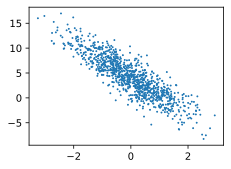

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [30]:
import random
'''
batch_size: 每个小批量包含的样本数量。
features: 输入的特征张量，形状通常是 (n,d)，其中 n 是样本数，d 是特征数。
labels: 输入的标签张量，形状是 (n,)，与样本一一对应
'''
def data_iter(batch_size, features, labels):
    num_examples = len(features) #获取数据集中样本的总数量
    indices = list(range(num_examples)) #创建一个从 0 到 num_examples-1 的索引列表
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) #原地打乱索引列表，使数据在每个 epoch 内以随机顺序迭代。
    for i in range(0, num_examples, batch_size): #以 batch_size 为步长遍历索引
        batch_indices = torch.tensor(
            #min(i + batch_size, num_examples) 确保取出的索引不会超过样本总数
            #对切片 indices[i:i+batch_size] 转为 PyTorch 张量，方便索引 features 和 labels
            indices[i: min(i + batch_size, num_examples)])
        #yield 是一个生成器，返回一个批量的特征和标签，而不是所有数据。
        #每次调用迭代器时计算下一个批量，从而节省内存。
        yield features[batch_indices], labels[batch_indices]

In [25]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.6664,  0.2001],
        [-1.0489, -1.6777],
        [-1.1013,  0.7642],
        [-0.8700, -0.0597],
        [-1.1725, -0.7466],
        [-0.2261,  1.8473],
        [ 2.1050, -1.2381],
        [ 2.2959,  1.3758],
        [-0.7490,  0.6322],
        [-1.6877, -0.1449]]) 
 tensor([[ 6.8700],
        [ 7.8253],
        [-0.6084],
        [ 2.6632],
        [ 4.3975],
        [-2.5424],
        [12.6161],
        [ 4.1199],
        [ 0.5342],
        [ 1.3192]])


In [28]:
#requires_grad=True 是用于设置张量是否需要参与自动求导（Autograd）的标志
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [14]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [15]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [31]:
'''
params: 模型的所有可训练参数（例如权重和偏置），通常是一个包含 torch.Tensor 的列表或迭代器。
lr: 学习率（learning rate），即每次更新的步长。
batch_size: 当前小批量的大小，用于在计算梯度时进行平均。
'''
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():#这个上下文管理器用于在优化过程中禁用自动求导机制
        for param in params:#遍历所有可训练的参数（权重、偏置等）
            param -= lr * param.grad / batch_size#是直接修改参数的值，而不是生成新的计算图
            param.grad.zero_()#在每次更新后，需要将梯度归零. _表示原地操作。

这段代码实现了**小批量随机梯度下降**（Stochastic Gradient Descent，SGD）优化器，用于更新模型的参数。下面详细解释代码的工作原理。

---

### **函数解析**
```python
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
```

#### **参数说明**
- **`params`**: 模型的所有可训练参数（例如权重和偏置），通常是一个包含 `torch.Tensor` 的列表或迭代器。
- **`lr`**: 学习率（learning rate），即每次更新的步长。
- **`batch_size`**: 当前小批量的大小，用于在计算梯度时进行平均。

#### **步骤解析**
1. **`with torch.no_grad()`**:
   - 这个上下文管理器用于在优化过程中禁用自动求导机制。这样，PyTorch 不会为参数更新计算新的梯度，节省计算资源和内存。
   - 更新步骤 `param -= lr * param.grad / batch_size` 是直接修改参数的值，而不是生成新的计算图。

2. **`for param in params:`**:
   - 遍历所有可训练的参数（权重、偏置等）。`params` 通常是一个包含 `torch.Tensor` 的列表，其中每个 `param` 是一个需要优化的参数。

3. **`param -= lr * param.grad / batch_size`**:
   - 这是SGD的核心更新规则，表示对每个参数 `param` 使用梯度下降法进行更新：
   $$
     \theta = \theta - \eta \times \frac{\nabla_{\theta} L}{m}
   $$
     - \( \theta \) 是要更新的参数（例如权重或偏置）。
     - \( \eta \) 是学习率（`lr`）。
     - \( \frac{\nabla_{\theta} L}{m} \) 是小批量的平均梯度，`param.grad` 是计算出的梯度，`batch_size` 用来计算小批量的平均梯度。

4. **`param.grad.zero_()`**:
   - 在每次更新后，需要将梯度归零。这是因为 PyTorch 默认会累加梯度，因此每次迭代后，需要手动清零梯度，否则梯度会累积，导致错误的更新。
   - `param.grad.zero_()` 是 PyTorch 中清空梯度的常见方法，`_` 表示原地操作。

---

### **SGD 优化器的工作流程**
- 在每个小批量训练时，通过 `param.grad` 获取当前小批量的梯度，并根据学习率和批量大小更新每个参数。
- 更新后，梯度会被清零，确保下一轮计算时梯度不会被累积。

---

### **完整示例**
假设你有一个简单的线性回归模型，并且已经计算好了损失和梯度，你可以使用 `sgd` 更新模型参数。

在每次 `sgd` 调用后，`w` 和 `b` 的值会发生更新，这有助于模型在训练过程中逐步逼近最优解。
---
### **注意事项**
1. **批量大小**：在更新时使用小批量的平均梯度。这样做的原因是小批量梯度下降（SGD）在每次迭代中计算出的梯度不如全量梯度准确，但具有较好的泛化能力。
2. **学习率**：合适的学习率对训练过程至关重要。过大可能导致发散，过小则训练速度过慢。
3. **自动清零梯度**：每次更新后，确保使用 `param.grad.zero_()` 清除梯度。


In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [22]:
batch_size = 10
'''
num_epochs：表示训练的总轮数（epoch）。
data_iter(batch_size, features, labels)：通过自定义的 data_iter 函数获取每个小批量的特征 X 和标签 y。batch_size 是小批量的大小，features 和 labels 是训练数据集的特征和标签。
每次迭代从 data_iter 获取一个批次的数据，然后对该批次计算损失并更新模型参数。
'''
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031093
epoch 2, loss 0.000112
epoch 3, loss 0.000046


In [23]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0010, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


# 3.3 线性回归的简洁实现

In [49]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

# 1. 生成数据集
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

# 2. 定义数据迭代器
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [50]:
next(iter(data_iter))

[tensor([[-0.7724, -0.9485],
         [ 0.7302,  1.0279],
         [-0.1041,  0.0121],
         [ 0.1494,  0.1968],
         [ 1.4341, -2.1819],
         [ 0.7033,  1.5089],
         [-0.5522, -0.7778],
         [-0.2495, -0.4514],
         [ 0.2750,  0.1719],
         [-0.0088, -0.7846]]),
 tensor([[ 5.8710],
         [ 2.1731],
         [ 3.9671],
         [ 3.8219],
         [14.4885],
         [ 0.4681],
         [ 5.7469],
         [ 5.2463],
         [ 4.1725],
         [ 6.8423]])]

In [51]:
# 3. 定义模型
from torch import nn
net = nn.Sequential(nn.Linear(2,1))#第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1

# 4. 初始化模型参数
net[0].weight.data.normal_(0, 0.1)
net[0].bias.data.fill_(0)

# 5. 定义损失函数和优化器
loss = nn.MSELoss()# 均方误差损失
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 6. 训练模型
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l= loss(net(X), y)  # 计算损失
        trainer.zero_grad() # 梯度清零
        l.backward()        # 反向传播
        trainer.step()      # 更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.000205
epoch 2, loss 0.000104
epoch 3, loss 0.000102


In [52]:
# 7. 打印学习到的参数
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0008,  0.0002])
b的估计误差： tensor([0.0014])
